In [1]:
# from future import print_function
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import torch.utils.data as data
from data import WiderFaceDetection, detection_collate, preproc, cfg_mnet, cfg_re50
from layers.modules import MultiBoxLoss
from layers.functions.prior_box import PriorBox
import time
import datetime
import math
from models.retinaface import RetinaFace
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
import detect_face_api
from data import cfg_mnet, cfg_re50
from models.retinaface import RetinaFace

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
# Declare config (use resnet50 backbone)
cfg = cfg_re50
rgb_mean = (104, 117, 123) # bgr order
num_classes = 2
img_dim = cfg['image_size']
num_gpu = cfg['ngpu']
batch_size = cfg['batch_size']
max_epoch = cfg['epoch']
gpu_train = cfg['gpu_train']

initial_lr = 1e-3
momentum = 0.9
weight_decay = 5e-4

In [5]:
# Instantiate model with the configurations above
net = RetinaFace(cfg=cfg_re50).to(device)
model_weights_path = './weights/Resnet50_Final.pth'
net = detect_face_api.load_model(net, model_weights_path, False)
net.train()

/common/home/users/n/nicoleoo.2021/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/common/home/users/n/nicoleoo.2021/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pretrained model from ./weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [6]:
import json
import detect_face_api

# -----------------
# Specify image path, model configuration, and model weights path
# -----------------
img_path = "images/monke.jpg"
model_weights_path = './weights/Resnet50_Final.pth'
output_img_path = "./test_outputs/monkey_og_output.jpg"

# -----------------
# Load the parameters for model from the JSON file (test_config.json, note that this is different from cfg as cfg is for the model architecture,
# but the json file specifies non-model related configurations like whether to save the image after running the model on the image etc
# -----------------
json_config_file_path = "./test_config.json"
with open(json_config_file_path, 'r') as file:
    test_config_json = json.load(file)
print(test_config_json)

detect_face_api.detect_face(img_path, model_weights_path, output_img_path, test_config_json)

{'cfg': 'cfg_re50', 'resize': 1, 'confidence_threshold': 0.02, 'top_k': 5000, 'keep_top_k': 750, 'nms_threshold': 0.4, 'save_image': True, 'vis_thres': 0.6}
Loading pretrained model from ./weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
net forward time: 0.2004


In [7]:
# Load an image for viewing
img = Image.open("images/monke.jpg")
img = np.array(img)

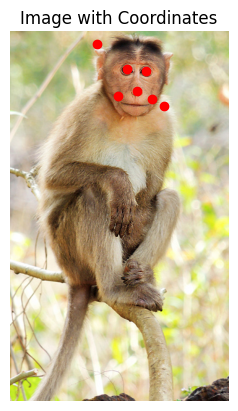

In [8]:
# This code is for locating landmarks on the monkey's face
coordinates = [(140, 20), (250, 120), (190, 60), (175, 105), (205, 96), (220, 63), (230, 110)]  # (x, y) format

plt.imshow(img)
plt.axis('off')

# Plot the coordinates
for coord in coordinates:
    plt.plot(coord[0], coord[1], 'ro')  # 'ro' means red circle

# Display the result
plt.title("Image with Coordinates")
plt.show()

In [9]:
# Load an image to use for FGSM
img = Image.open("images/monke.jpg")
img = np.array(img)

In [10]:
# Define targets
annotations = np.zeros((0, 15))
annotation = np.zeros((1, 15))
# bbox
annotation[0, 0] = 140  # x1
annotation[0, 1] = 20  # y1
annotation[0, 2] = 110  # x2
annotation[0, 3] = 100  # y2

# landmarks
annotation[0, 4] = 190    # l0_x
annotation[0, 5] = 60    # l0_y
annotation[0, 6] = 175    # l1_x
annotation[0, 7] = 105    # l1_y
annotation[0, 8] = 205   # l2_x
annotation[0, 9] = 96   # l2_y
annotation[0, 10] = 220  # l3_x
annotation[0, 11] = 63  # l3_y
annotation[0, 12] = 230  # l4_x
annotation[0, 13] = 110  # l4_y
annotations = np.append(annotations, annotation, axis=0)
target = np.array(annotations)

In [11]:
preproc_inst = preproc(img_dim, rgb_mean)
img, target = preproc_inst(img, target)

In [12]:
# Image and Label processing
# Add batch dimension for images
target = torch.Tensor(target)
target = target.unsqueeze(0)
img = torch.Tensor(img)
img = img.unsqueeze(0)
img = img.cuda()
img.requires_grad = True
targets = [anno.cuda() for anno in target]

In [13]:
# Initialise optimisers
optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
criterion = MultiBoxLoss(num_classes, 0.35, True, 0, True, 7, 0.35, False)

In [14]:
# Initialise anchor boxes for the RetinaFace model
priorbox = PriorBox(cfg, image_size=(img_dim, img_dim))
with torch.no_grad():
    priors = priorbox.forward()
    priors = priors.cuda()

In [15]:
# Save a copy of the original image to be modified by the gradients later in FGSM
x_adv = img.detach().clone()
x_adv.requires_grad = True

In [16]:
# FGSM Attack
# Forward
out = net(img)
print(targets)
# backprop
optimizer.zero_grad()
loss_l, loss_c, loss_landm = criterion(out, priors, targets)
loss = cfg['loc_weight'] * loss_l + loss_c + loss_landm
loss.backward()

[tensor([[0.2333, 0.0333, 0.1833, 0.1667, 0.3167, 0.1000, 0.2917, 0.1750, 0.3417,
         0.1600, 0.3667, 0.1050, 0.3833, 0.1833, 0.0000]], device='cuda:0')]


In [17]:
# FGSM Attack
eps = 0.00001
print(x_adv.shape)
grad_data = img.grad.data
x_adv = torch.clamp(x_adv - eps * grad_data.sign(), 0, 1).detach().clone()

# Permute dimensions for saving
x_adv_permuted_tensor = x_adv.squeeze(0).cpu() * 255
x_adv_permuted_tensor = x_adv_permuted_tensor.permute(1, 2, 0)
x_adv_no_batch = np.array(x_adv_permuted_tensor, dtype=np.uint8)
# x_adv_no_batch_bgr = cv2.cvtColor(x_adv_no_batch, cv2.COLOR_RGB2BGR)
print(x_adv_no_batch.shape)

# Save the adversarial image
cv2.imwrite("test_outputs/x_adv.jpg", x_adv_no_batch)

torch.Size([1, 3, 840, 840])
(840, 840, 3)


/tmp/ipykernel_2350383/1158458956.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_adv_no_batch = np.array(x_adv_permuted_tensor, dtype=np.uint8)


True

In [18]:
import json
import detect_face_api

# -----------------
# Specify image path, model configuration, and model weights path
# -----------------
img_path = "test_outputs/x_adv.jpg"
model_weights_path = './weights/Resnet50_Final.pth'
output_img_path = "./test_outputs/adv_test_.jpg"

# -----------------
# Load the parameters for model from the JSON file (test_config.json, note that this is different from cfg as cfg is for the model architecture,
# but the json file specifies non-model related configurations like whether to save the image after running the model on the image etc
# -----------------
json_config_file_path = "./test_config.json"
with open(json_config_file_path, 'r') as file:
    test_config_json = json.load(file)
print(test_config_json)

detect_face_api.detect_face(img_path, model_weights_path, output_img_path, test_config_json)

{'cfg': 'cfg_re50', 'resize': 1, 'confidence_threshold': 0.02, 'top_k': 5000, 'keep_top_k': 750, 'nms_threshold': 0.4, 'save_image': True, 'vis_thres': 0.6}
Loading pretrained model from ./weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
net forward time: 0.0140
